In [10]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from em import *
import matplotlib.pyplot as plt
import random
import math
import warnings

sample_sizes = [50, 100, 200, 500]

In [25]:
"""
1. Generate synthetic data from a 3-mode gaussian mixture model
"""

x1_random = generate_data(1000, num_modes=1).x
x2_random = generate_data(1000, num_modes=2).x
x3_random = generate_data(1000, num_modes=3).x

Means = 48, Vars = 3, Weights = 1.0
Means = 25, 87, Vars = 3, 2, Weights = 0.82, 0.18
Means = 20, 28, 80, Vars = 2, 2, 1, Weights = 0.59, 0.31, 0.1


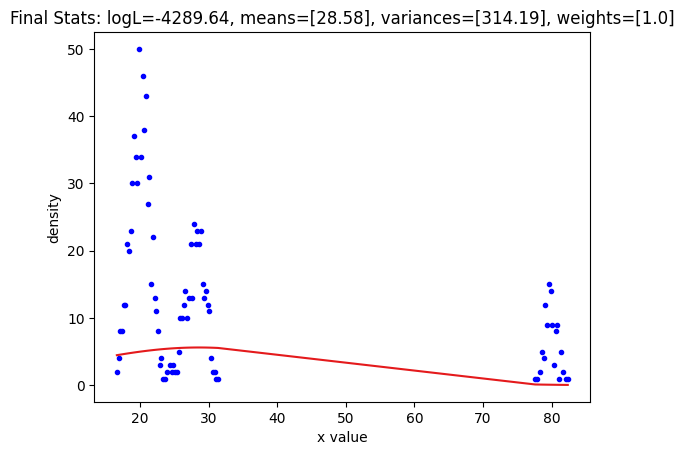

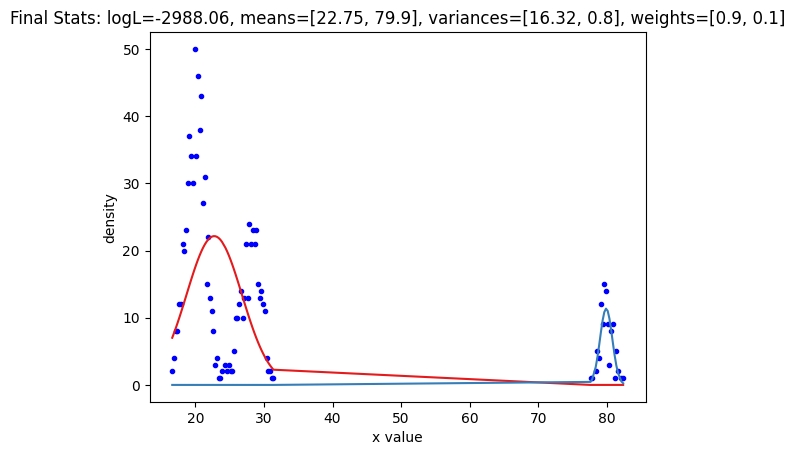

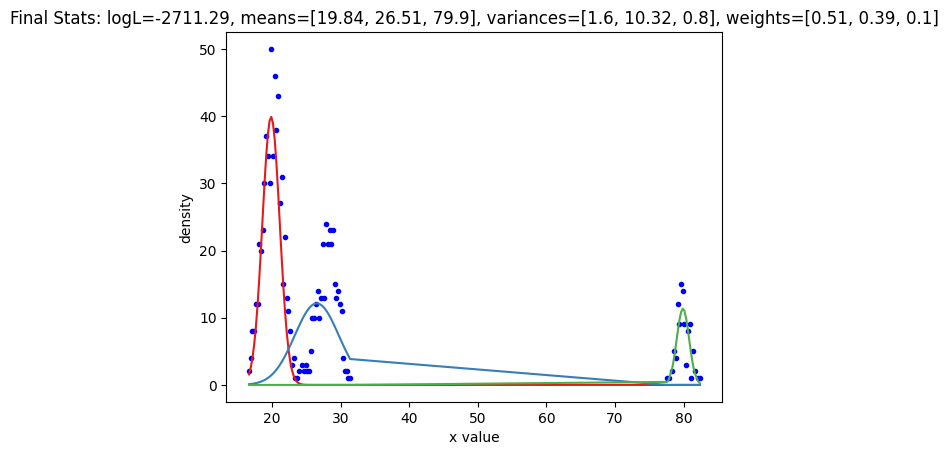


Number of SVs: 3
logL=-2711.29, means=[19.84, 26.51, 79.9], variances=[1.6, 10.32, 0.8], weights=[0.51, 0.39, 0.1]


EstimatedGMM(mu=[19.84183073047633, 26.506121774685386, 79.89826710124946], vr=[1.6010352173966458, 10.319181102437277, 0.802889225539571], p=array([0.50662406, 0.39127384, 0.1021021 ]), num_modes=3, aic=5438.587883717883, outliers=None)

In [26]:
"""
2. Estimate the parameters via EM
"""

run_gmm(x3_random)

In [31]:
threshold_mu = 1 # values between 0 and 100
threshold_vr = 0.5 # values between 1 and 5
threshold_p = 0.05 # values between 0.1 and 0.9

sample_sizes = [20, 100, 1000, 10000]
num_tests_per_sample = 100

for num_samples in sample_sizes:
  passed_tests = []
  failed_tests = []
  for num_modes in range(1, 4):
    for _ in range(num_tests_per_sample):
      data = generate_data(num_samples, num_modes=num_modes, pr=False)
      gmm = run_gmm(data.x, plot=False, pr=False)
      passed = True
      for actual_vals, estimated_vals, threshold in zip([data.mu, data.vr, data.p], [gmm.mu, gmm.vr, gmm.p], [threshold_mu, threshold_vr, threshold_p]):
        for actual_val, estimated_val in zip(actual_vals, estimated_vals):
          if abs(actual_val - estimated_val) >= threshold:
            # print(num_samples, data.mu, gmm.mu, data.vr, gmm.vr, data.p, gmm.p)
            failed_tests.append(data)
            passed = False
            break
        if not passed:
          break
      if passed:
        passed_tests.append(data)

  print(f"{len(failed_tests)}/{3 * num_tests_per_sample} tests failed for data with {num_samples} samples.")

/Users/vivian/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/vivian/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/vivian/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/vivian/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/vivian/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


262/300 tests failed for data with 20 samples. 
196/300 tests failed for data with 100 samples. 
112/300 tests failed for data with 1000 samples. 
71/300 tests failed for data with 10000 samples. 


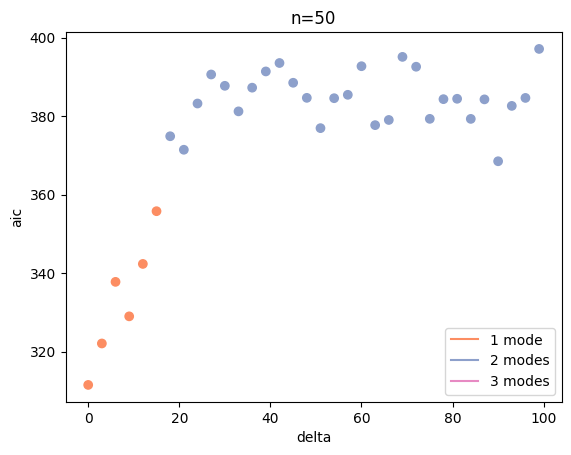

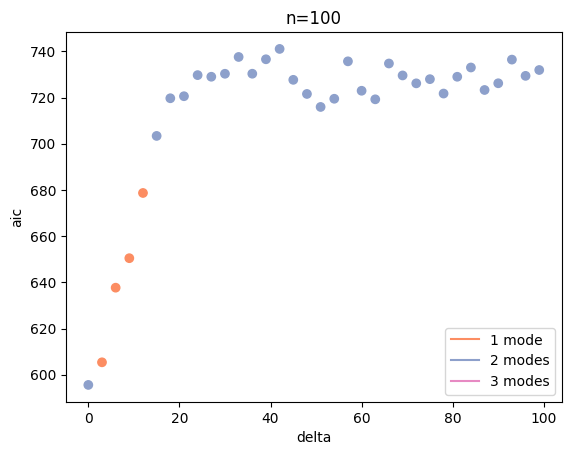

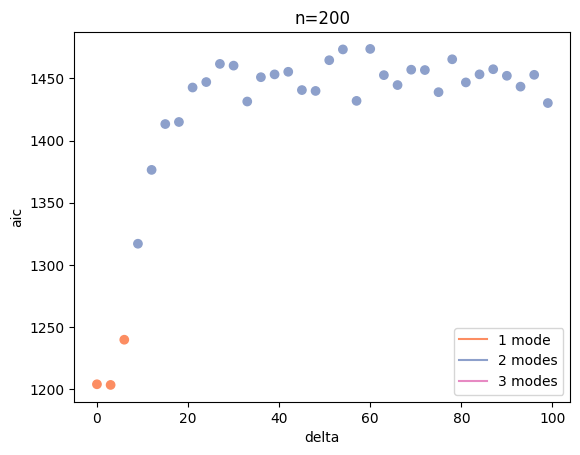

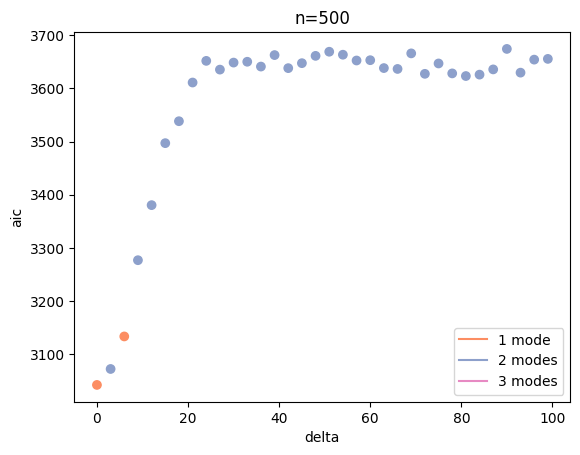

In [43]:
# Experiment 1: vary the separation sigma between 2 modes, from delta = 0 to delta >> 0
# Expect to see 1 mode for low delta values, 2 modes for high delta values

for n in sample_sizes:
    sig = 5
    p1 = 0.7
    p2 = 0.3

    mu1 = 1000000
    sample_data = generate_data(n, mode_means=np.array([mu1]), mode_variances=np.array([sig**2]), weights=np.array([1]), pr=False)
    x1 = sample_data.x

    gmm_by_delta = {}
    for delta in range(0, 100, 3):
        x2 = [x + delta for x in x1]
        x = random.sample(list(x1), math.ceil(p1 * n)) + random.sample(x2, math.ceil(p2 * n))
        gmm = run_gmm(x, plot=False, pr=False)
        gmm_by_delta[delta] = gmm

    # plot the adjusted log-likelihoods for the 3 fitted models as a function of delta
    plot_param_vs_aic(n, gmm_by_delta, "delta")

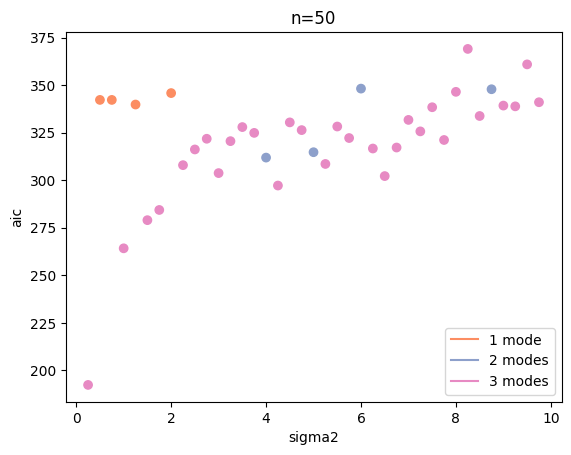

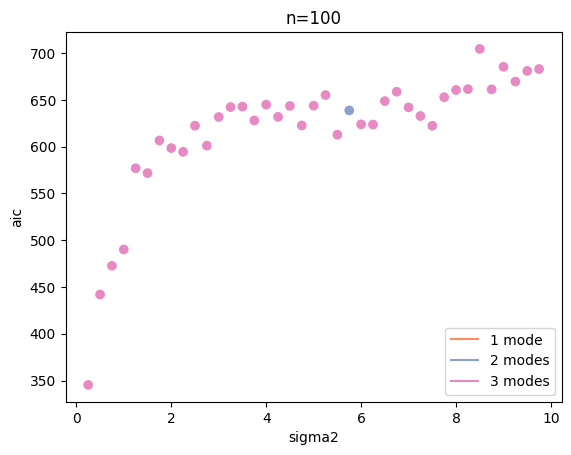

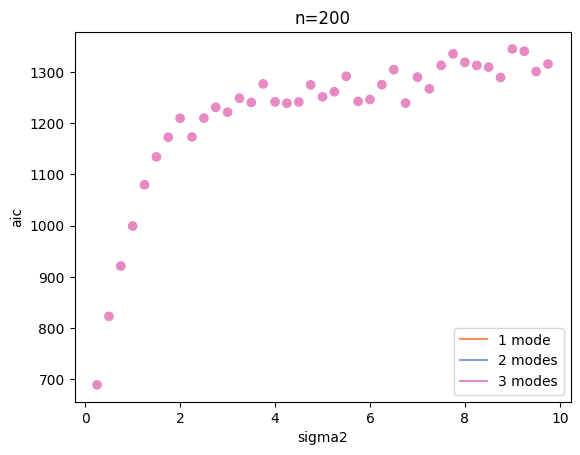

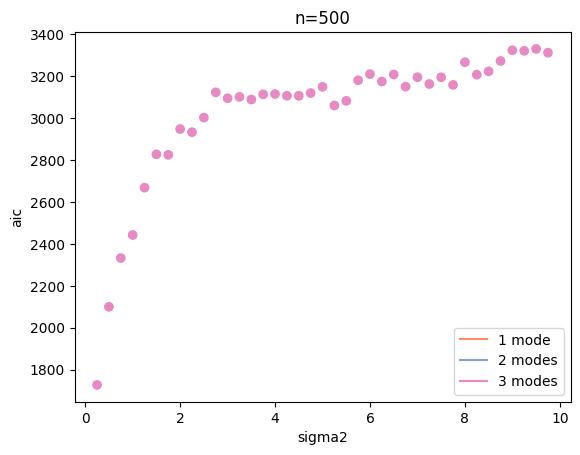

In [44]:
# Experiment 2: vary the variance of the middle mode from small to very large
# Expect to see 3 modes for low variance, 1-2 modes for high variance, mistakes decrease with sample size

mu = np.array([10, 20, 30])
p = np.array([0.2, 0.5, 0.3])

for n in sample_sizes:
    gmm_by_sig2 = {}
    for sig2 in np.arange(0.25, 10, 0.25):
        vr = np.array([1, sig2**2, 1])
        data = generate_data(n, mode_means=mu, mode_variances=vr, weights=p, pr=False)
        gmm = run_gmm(data.x, plot=False, pr=False)
        gmm_by_sig2[sig2] = gmm

    plot_param_vs_aic(n, gmm_by_sig2, "sigma2")

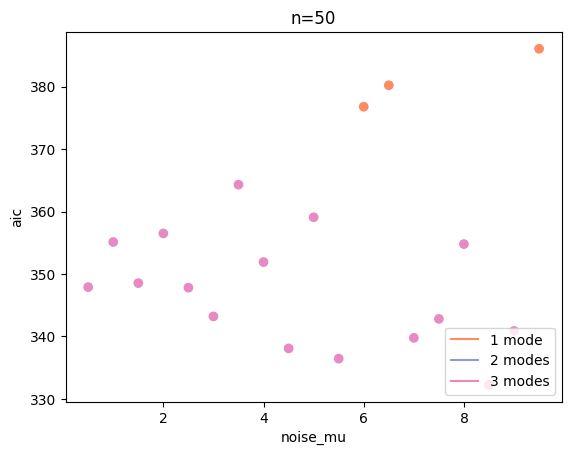

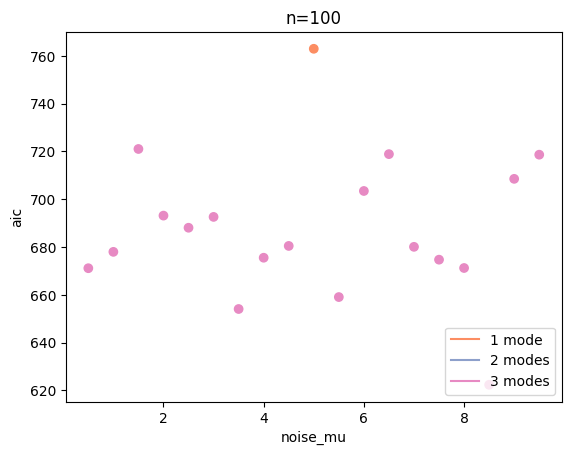

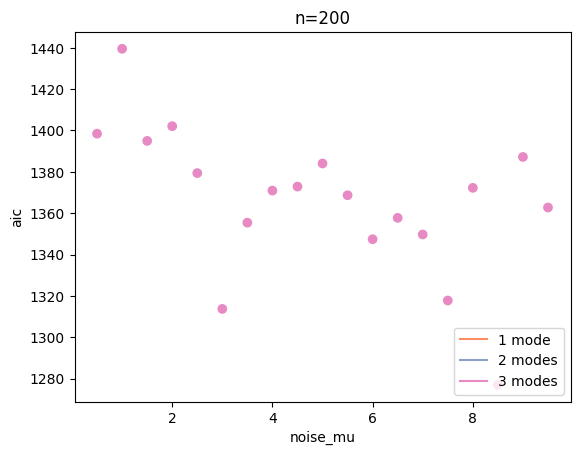

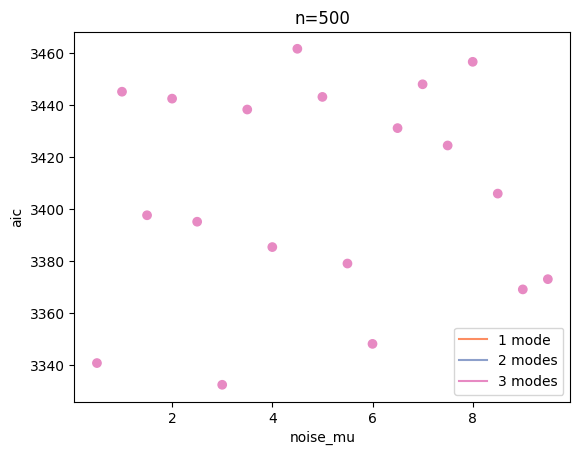

In [60]:
# Experiment 3: Introduce noise to data points
# Expect to see 3 modes when n is large and noise is small, 1-2 modes possible when lots of noise or small sample size

mu = np.array([0, 15, 30])
vr = np.array([1, 2, 1])
p = np.array([0.3, 0.5, 0.2])

for n in sample_sizes:
    gmm_by_noise = {}
    for m in np.arange(0.5, 10, 0.5):
        x = generate_data(n, mode_means=mu, mode_variances=vr, weights=p, pr=False).x
        noise = np.random.normal(m, 2, x.shape)
        x = list(x) + noise
        gmm = run_gmm(x, plot=False, pr=False)
        gmm_by_noise[m] = gmm

    plot_param_vs_aic(n, gmm_by_noise, "noise_mu")


In [13]:
# Experiment 4: Outlier with 1 mode

warnings.filterwarnings("ignore")

mu = np.array([1000000])
vr = np.array([1])
p = np.array([1])

for n in [50]:
    gmm_by_delta = {}
    for delta in range(95, 100, 5):
        x = generate_data(n, mode_means=mu, mode_variances=vr, weights=p, pr=False).x
        x = np.append(x, mu[0] + delta)
        gmm = run_gmm(x, plot=False, pr=False)
        gmm_by_delta[delta] = gmm

    # plot_param_vs_aic(n, gmm_by_delta, "delta_outlier")

1 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers
removing 0 outliers


In [ ]:
# Experiment 5: Outlier with 2 modes

warnings.filterwarnings("ignore")

mu = np.array([1000000, 1000005])
vr = np.array([1, 1])
p = np.array([0.5, 0.5])

for n in [50]:
    gmm_by_delta = {}
    for delta in range(5, 100, 5):
        x = generate_data(n, mode_means=mu, mode_variances=vr, weights=p, pr=False).x
        x = np.append(x, mu[1] + delta)
        gmm = run_gmm(x, plot=False, pr=False)
        gmm_by_delta[delta] = gmm

    # plot_param_vs_aic(n, gmm_by_delta, "delta_outlier")

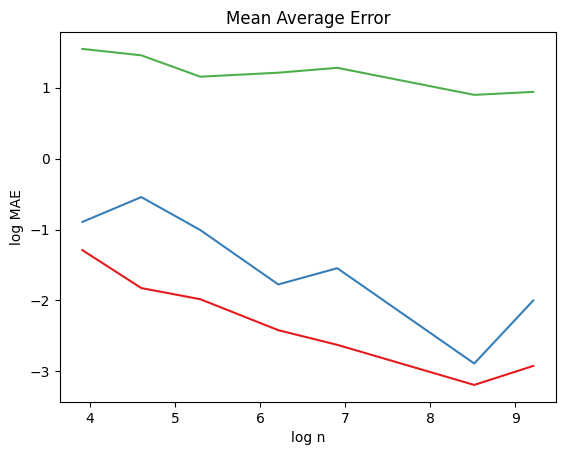

In [27]:
# Plot mean average error to measure statistical consistency

num_trials = 100

log_n = []
log_mae = [[] for _ in range(3)]
for n in [50, 100, 200, 500, 1000, 5000, 10000]:
   log_n.append(np.log(n))
   for num_modes in range(1, 4):
      all_mae = []
      for _ in range(num_trials):
         sample_data = generate_data(n, num_modes=num_modes, pr=False)
         gmm = run_gmm(sample_data.x, plot=False, pr=False)
         mae = calc_mae(sample_data.mu, gmm.mu)
         all_mae.append(mae)
      avg_mae = sum(all_mae)/len(all_mae)
      log_mae[num_modes - 1].append(np.log(avg_mae))

plot_mae(log_n, log_mae)